In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm


from apelfei.statistics.general import fpf_2_gaussian_sigma, gaussian_sigma_2_fpf
from apelfei.utils import center_subpixel
from apelfei.utils.data_handling import load_adi_data
from apelfei.utils.aperture_photometry import flux_ratio2mag, mag2flux_ratio, AperturePhotometryMode
from apelfei.utils.aperture_positions import estimate_reference_positions

from apelfei.contrast import collect_all_data_setup_configs, ContrastResults, estimate_stellar_flux,\
    read_and_sort_results, compute_detection_confidence
from apelfei.statistics.parametric import TTest

Found installation of parallel_sort and use it.


## This Code is About

This code shows an alternative to contrast curves which allows to compute contrast limits: The contrast map. The code calculate the results and gives the Figure 13 in the paper.

## Load all config files and residuals

In [2]:
experiment_root = "../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/"

In [3]:
all_configs = collect_all_data_setup_configs(os.path.join(experiment_root, 
                                                          "configs_cmap"))

In [4]:
# collect all the residual files with configs
all_method_results = dict()
algorithm_config_dir = os.path.join(experiment_root, "configs_algo")

for tmp_file in sorted(os.listdir(algorithm_config_dir)):
    # ignore system files
    if tmp_file.startswith("."):
        continue

    tmp_algo_config_file = os.path.join(algorithm_config_dir, tmp_file)
    with open(tmp_algo_config_file) as json_file:
        tmp_algorithm_config = json.load(json_file)
    
    tmp_algo = tmp_algorithm_config['method_name']
    print("Found algorithm config file for method " + str(tmp_algo))
    print("Collecting residuals...")
    
    # Loop over all fake planet experiments
    tmp_all_results = []
    for tmp_config in all_configs:
        tmp_id, tmp_cmap_config_file = tmp_config
        
        tmp_residual_file = os.path.join(experiment_root, 
                                         "pca_residuals",
                                         tmp_algo +"_ID_" + tmp_id + ".fits")
                  
        # save residual and config file paths
        tmp_all_results.append((tmp_cmap_config_file, tmp_residual_file))
        
    print("[DONE] - Found " + str(len(tmp_all_results)) + " residuals.")
    all_method_results[tmp_algo] = tmp_all_results

Found algorithm config file for method pca_005
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_010
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_020
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_030
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_040
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_050
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_075
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_100
[DONE] - Found 2017 residuals.


## Read the data for the PSF template data

In [5]:
dataset_json_file = os.path.join(experiment_root, "dataset.json")
config_dir = os.path.join(experiment_root, "configs_cmap")
algo_config_root = os.path.join(experiment_root, "configs_algo")
residual_result_dir = os.path.join(experiment_root, "pca_residuals")

with open(dataset_json_file) as json_file:
    tmp_dataset_config = json.load(json_file)

In [6]:
# we need the psf template for contrast calculation
science_data, _, raw_psf_template_data = load_adi_data(tmp_dataset_config["file_path"],
                                                       data_tag=tmp_dataset_config["stack_key"],
                                                       psf_template_tag=tmp_dataset_config["psf_template_key"],
                                                       para_tag=tmp_dataset_config["parang_key"])

dit_psf_template = tmp_dataset_config["dit_psf_template"]
dit_science = tmp_dataset_config["dit_science"]

In [7]:
# Cut the data to the innermost 8 lambda / D
crop_science = tmp_dataset_config["crop_science"]
crop_template = tmp_dataset_config["crop_template"]

science_data = science_data[:,
                            crop_science:-crop_science,
                            crop_science:-crop_science]

psf_template_data = raw_psf_template_data[crop_template:-crop_template, 
                                          crop_template:-crop_template]

test_frame = science_data[0, :, :]

## Create the Contrast Evaluator - photometry on pixel

In [8]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [9]:
# 1.) Compute the stellar flux
stellar_flux = estimate_stellar_flux(
    psf_template=psf_template_data,
    dit_science=tmp_dataset_config["dit_science"],
    dit_psf_template=tmp_dataset_config["dit_psf_template"],
    photometry_mode=photometry_mode_planet,
    scaling_factor=1.)

In [10]:
contrast_results = dict()

for pca_setup, result_files in all_method_results.items():
    print(pca_setup)
    tmp_contrast_result = ContrastResults(model_results_in=result_files,
                                          stellar_flux=stellar_flux,
                                          planet_photometry_mode=photometry_mode_planet,
                                          noise_photometry_mode=photometry_mode_noise,
                                          psf_fwhm_radius=2.1)
    contrast_results[pca_setup] = tmp_contrast_result

pca_005
pca_010
pca_020
pca_030
pca_040
pca_050
pca_075
pca_100


In [11]:
contrast_result1 = contrast_results["pca_010"]
contrast_result2 = contrast_results["pca_050"]

## Compute the contrast curves

In [12]:
ttest_statistic = TTest()

In [13]:
median_contrast_1, contrast_error_1 = contrast_result1.compute_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    test_statistic=ttest_statistic,
    num_rot_iterations=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:48<00:00, 18.05s/it]


In [14]:
median_contrast_2, contrast_error_2 = contrast_result2.compute_contrast_curve(
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    test_statistic=ttest_statistic,
    num_rot_iterations=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [04:52<00:00, 18.27s/it]


## Compute the Contrast map

In [15]:
contrast_map1, contrast_map_curve1 = contrast_result1.compute_contrast_map(
    test_statistic=ttest_statistic,
    num_cores=120,
    num_rot_iter=20,
    safety_margin=1.0,
    contrast_curve_fpf=gaussian_sigma_2_fpf(5))

Computing contrast map with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]


In [16]:
contrast_map2, contrast_map_curve2 = contrast_result2.compute_contrast_map(
    test_statistic=ttest_statistic,
    num_cores=120,
    num_rot_iter=20,
    safety_margin=1.0,
    contrast_curve_fpf=gaussian_sigma_2_fpf(5))

Computing contrast map with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]


## Create the Plot

In [17]:
color_palette = [sns.color_palette("colorblind")[1],
                 sns.color_palette("colorblind")[8]]

#color_palette = sns.color_palette("hls", 2)
color_palette

[(0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

In [18]:
separations = contrast_map_curve2.index/4.2

In [19]:
def plot_contrast_curve(separations_in,
                        median_contrast,
                        contrast_error,
                        label, 
                        axis):
    axis.plot(separations_in, 
              flux_ratio2mag(median_contrast), 
              label=label,
              lw=3)
    
    if contrast_error is not None:
        axis.fill_between(separations_in,
                          flux_ratio2mag(median_contrast + contrast_error * 2), 
                          flux_ratio2mag(median_contrast - contrast_error * 2),
                          alpha=0.5)

/home/ipa/quanz/user_accounts/mbonse/2022_EpsEri/50_code/venv_eps_eri/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


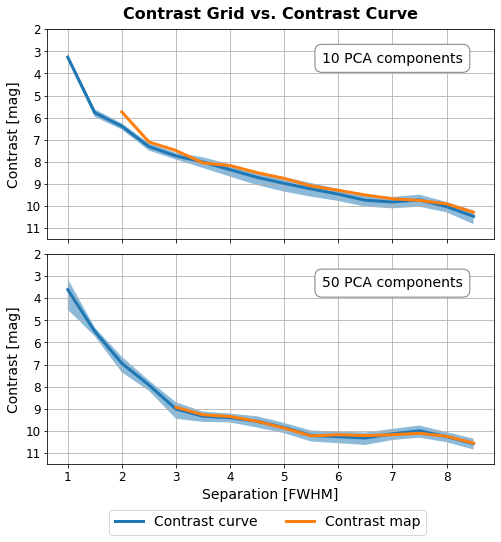

In [21]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
gs0 = fig.add_gridspec(2, 1)
gs0.update(hspace=0.07, wspace=0.09)

axis_pca_10 = fig.add_subplot(gs0[0])
axis_pca_50 = fig.add_subplot(gs0[1])

# Plot the first comparison at 20 pca
plot_contrast_curve(separations, median_contrast_1, contrast_error_1, 
                    "Contrast curve", axis_pca_10)
plot_contrast_curve(separations, contrast_map_curve1, None, 
                    "Contrast map", axis_pca_10)

axis_pca_10.set_ylim(11.5, 2.5)
axis_pca_10.grid()
plt.setp(axis_pca_10.get_xticklabels(), visible=False)

axis_pca_10.text(7, 3.5, r"10 PCA components",
             ha="center", fontsize=14, #fontweight="bold",
             bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))

# Plot the first comparison at 50 pca
plot_contrast_curve(separations, median_contrast_2, contrast_error_2, 
                    "Contrast Curve", axis_pca_50)
plot_contrast_curve(separations, contrast_map_curve2, None, 
                    "Contrast Map", axis_pca_50)

axis_pca_50.set_ylim(11.5, 2.5)
axis_pca_50.grid()

axis_pca_50.text(7, 3.5, r"50 PCA components",
             ha="center", fontsize=14, #fontweight="bold",
             bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))

# Labels
axis_pca_50.set_xlabel(r"Separation [FWHM]", size=14)
axis_pca_50.set_ylabel(r"Contrast [mag]", size=14)
axis_pca_10.set_ylabel(r"Contrast [mag]", size=14)
axis_pca_10.set_yticks(np.arange(2, 12, 1))
axis_pca_50.set_yticks(np.arange(2, 12, 1))
axis_pca_10.tick_params(axis='both', which='major', labelsize=12)
axis_pca_50.tick_params(axis='both', which='major', labelsize=12)
axis_pca_10.set_title("Contrast Grid vs. Contrast Curve",
                      fontsize=16, fontweight="bold", y=1.02)

# Legend
handles, labels = axis_pca_10.get_legend_handles_labels()
leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.22, -0.01),
                  loc='lower left', ncol=2, fontsize=14)
plt.setp(leg1.get_title(),fontsize=14)


fig.patch.set_facecolor('white')
plt.savefig("./13_Contrast_grid_vs_curve.pdf", 
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')